In [47]:
import sys, numpy as np, pandas as pd, sklearn, matplotlib
np.random.seed(42)

pd.set_option("display.width", 120)
pd.set_option("display.max_columns", 50)

print(sys.version)
print("pandas", pd.__version__, "sklearn", sklearn.__version__, "matplotlib", matplotlib.__version__)

3.13.5 (v3.13.5:6cb20a219a8, Jun 11 2025, 12:23:45) [Clang 16.0.0 (clang-1600.0.26.6)]
pandas 2.3.0 sklearn 1.7.0 matplotlib 3.10.3


In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [49]:
file_path = Path("..") / "data" / "bestsellers.csv"

df = pd.read_csv(file_path)
dfc = df.copy()

In [50]:
# Exploring the data

# first 5 rows of the spreadsheet
print(dfc.head())

# shape of the spreadsheet
print(dfc.shape)

# column names
print(dfc.columns)

# summary statistics for each column
print(dfc.describe())

                                                Name                    Author  User Rating  Reviews  Price  Year  \
0                      10-Day Green Smoothie Cleanse                  JJ Smith          4.7    17350      8  2016   
1                                  11/22/63: A Novel              Stephen King          4.6     2052     22  2011   
2            12 Rules for Life: An Antidote to Chaos        Jordan B. Peterson          4.7    18979     15  2018   
3                             1984 (Signet Classics)             George Orwell          4.7    21424      6  2017   
4  5,000 Awesome Facts (About Everything!) (Natio...  National Geographic Kids          4.8     7665     12  2019   

         Genre  
0  Non Fiction  
1      Fiction  
2  Non Fiction  
3      Fiction  
4  Non Fiction  
(550, 7)
Index(['Name', 'Author', 'User Rating', 'Reviews', 'Price', 'Year', 'Genre'], dtype='object')
       User Rating       Reviews       Price         Year
count   550.000000    550.000000  

In [51]:
# renaming some columns for convenience
dfc.rename(columns={"Name": "Title", "Year": "Publication Year", "User Rating": "Rating"})

,Title,Author,Rating,Reviews,Price,Publication Year,Genre
0,10-Day Green Smoothie Cleanse,JJ Smith,4.7,17350,8,2016,Non Fiction
1,11/22/63: A Novel,Stephen King,4.6,2052,22,2011,Fiction
2,12 Rules for Life: An Antidote to Chaos,Jordan B. Peterson,4.7,18979,15,2018,Non Fiction
3,1984 (Signet Classics),George Orwell,4.7,21424,6,2017,Fiction
4,"5,000 Awesome Facts (About Everything!) (Natio...",National Geographic Kids,4.8,7665,12,2019,Non Fiction
...,...,...,...,...,...,...,...
545,Wrecking Ball (Diary of a Wimpy Kid Book 14),Jeff Kinney,4.9,9413,8,2019,Fiction
546,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2016,Non Fiction
547,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2017,Non Fiction
548,You Are a Badass: How to Stop Doubting Your Gr...,Jen Sincero,4.7,14331,8,2018,Non Fiction


In [52]:
# Cleaning Process

# dropping any duplicates within the dataset
dfc.drop_duplicates(inplace=True)

# renaming some columns for convenience
dfc.rename(columns={"Name": "Title", "Year": "Publication Year", "User Rating": "Rating"}, inplace=True)

# visualize chnage
dfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Title             550 non-null    object 
 1   Author            550 non-null    object 
 2   Rating            550 non-null    float64
 3   Reviews           550 non-null    int64  
 4   Price             550 non-null    int64  
 5   Publication Year  550 non-null    int64  
 6   Genre             550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 30.2+ KB


In [53]:
# add some feature engineering

# visualize the column so I decide the price ranges
summary = dfc["Price"].describe()

print(summary)

count    550.000000
mean      13.100000
std       10.842262
min        0.000000
25%        7.000000
50%       11.000000
75%       16.000000
max      105.000000
Name: Price, dtype: float64


In [54]:
# recategorize price column into 'budget', 'mid-range', 'premium'

# create a bin, each number is a cut-off point. it ends at 106, that's because our max is 105 so we add 1 in order to make sure it's included
bins = [0, 8, 16, dfc["Price"].max() + 1]

# just define labels
labels = ["Budget", "Mid-Range", "Premium"]

# now use pd.cut() to create a new column in our dataset
dfc["Price_Tier"] = pd.cut(
    x=dfc["Price"], # here we're telling pd.cut() what column we want to categorize
    bins=bins, # our boundaries we created above
    labels=labels, # our labels also created above
    include_lowest=True # making sure the lowest value (0) is included in the first bin
)

# now check our work 
print(dfc["Price_Tier"].value_counts())

Price_Tier
Mid-Range    228
Budget       200
Premium      122
Name: count, dtype: int64


In [55]:
# begin analyzing 
# calculate if the number of words in a title influence the rating its given

# create our new column. 
# we use str.split() to break the title string into a list of individual words
# we use str.len() to count how many words are in the resulting list
dfc["Title_Word_Count"] = dfc["Title"].str.split().str.len()
print(dfc[["Title", "Title_Word_Count"]].head())

                                               Title  Title_Word_Count
0                      10-Day Green Smoothie Cleanse                 4
1                                  11/22/63: A Novel                 3
2            12 Rules for Life: An Antidote to Chaos                 8
3                             1984 (Signet Classics)                 3
4  5,000 Awesome Facts (About Everything!) (Natio...                 8


count    550.000000
mean       8.138182
std        4.818660
min        1.000000
25%        4.000000
50%        7.000000
75%       12.000000
max       24.000000
Name: Title_Word_Count, dtype: float64


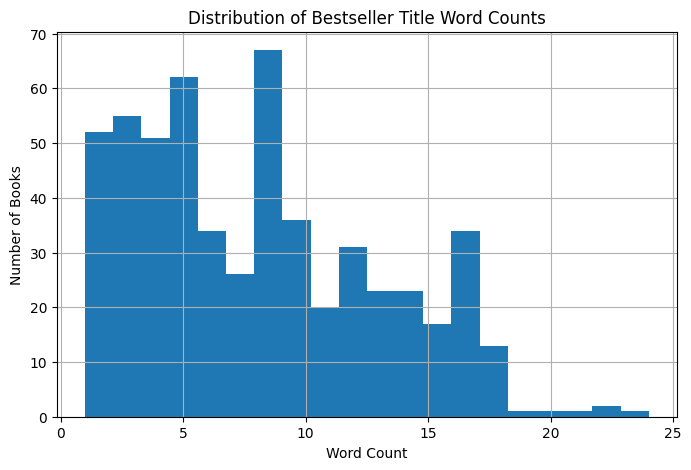

In [56]:
#analyzing our numerical distribution
print(dfc["Title_Word_Count"].describe())

# histogram
plt.figure(figsize=(8, 5))
dfc["Title_Word_Count"].hist(bins=20) #.hist is what tells py to make a histogram and the bins is what determines how the data is grouped
plt.title("Distribution of Bestseller Title Word Counts")
plt.xlabel("Word Count")
plt.ylabel("Number of Books")

# put figure inside folder and show
plt.savefig("../figures/title_word_count", bbox_inches="tight")
plt.show()

In [57]:
# more analyzing

author_count = dfc["Author"].value_counts()
print(author_count)

Author
Jeff Kinney                           12
Gary Chapman                          11
Rick Riordan                          11
Suzanne Collins                       11
American Psychological Association    10
                                      ..
Keith Richards                         1
Chris Cleave                           1
Alice Schertle                         1
Celeste Ng                             1
Adam Gasiewski                         1
Name: count, Length: 248, dtype: int64


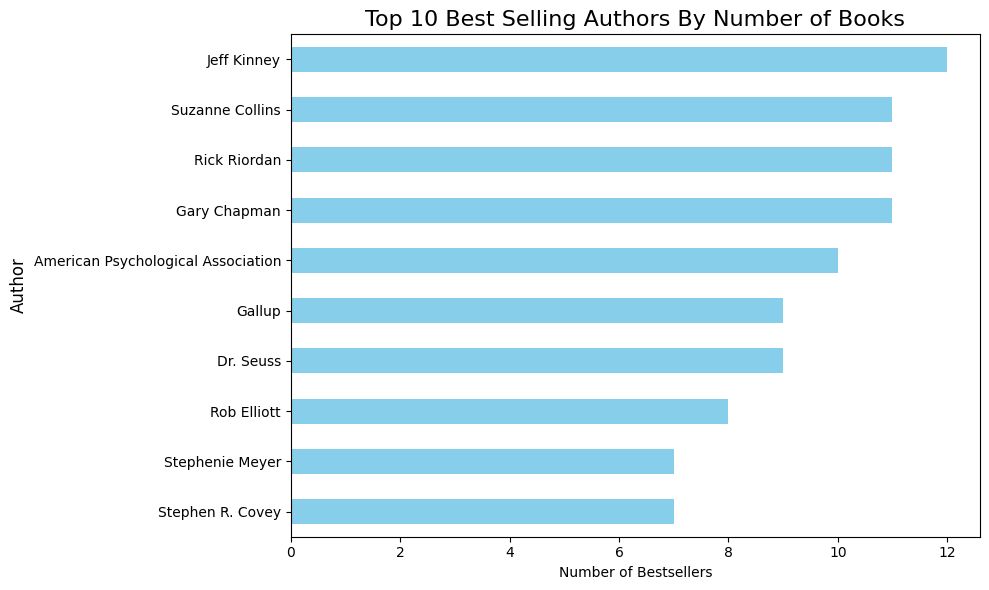

In [58]:
# visualizing top authors

# only top 10
top_10_authors = author_count.head(10).sort_values(ascending=True)

plt.figure(figsize=(10, 6))
top_10_authors.plot(kind="barh", color="skyblue")

# titles & labels
plt.title("Top 10 Best Selling Authors By Number of Books", fontsize=16)
plt.xlabel("Number of Bestsellers")
plt.ylabel("Author", fontsize=12)

# preventing label cut off
plt.tight_layout()

# put figure inside folder
plt.savefig("../figures/top_selling_authors_by_n_of_books.png", bbox_inches="tight")


In [59]:
avg_rating_by_genre = dfc.groupby("Genre")["Rating"].mean()
print(avg_rating_by_genre)

Genre
Fiction        4.648333
Non Fiction    4.595161
Name: Rating, dtype: float64


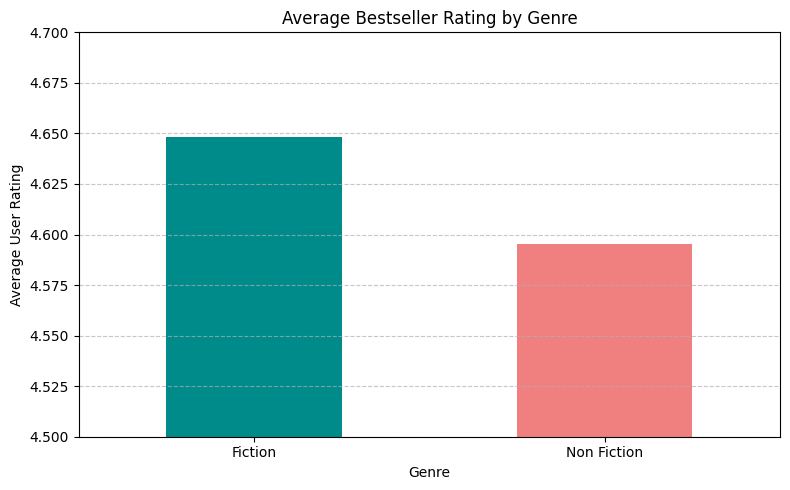

In [60]:
# visualizing the above

plt.figure(figsize=(8, 5))

# plot data
avg_rating_by_genre.plot(kind="bar", color=["darkcyan", "lightcoral"])

# add titles and labels
plt.title("Average Bestseller Rating by Genre")
plt.xlabel("Genre")
plt.ylabel("Average User Rating")

# apply zoom since it's very similar
plt.ylim(4.5, 4.7)

# customization for visuals
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()

# put figure inside folder
plt.savefig("../figures/avg_rating_by_genre_barchart.png", bbox_inches="tight")

In [61]:
# this is where we will determine if a longer/shorter title influences the rating

# same as below, create a bin and labels
title_bins = [0, 4, 8, dfc["Title_Word_Count"].max() + 1]
title_labels = ["Short", "Medium", "Long"]

# create a tier
dfc["Title_Length_Tier"] = pd.cut(
    dfc["Title_Word_Count"],
    bins=title_bins,
    labels=title_labels,
    include_lowest=True
)

# group by the new tier we created than calculate the avg
avg_rating_by_length = dfc.groupby("Title_Length_Tier")["Rating"].mean()

print(avg_rating_by_length)



Title_Length_Tier
Short     4.594937
Medium    4.634932
Long      4.623577
Name: Rating, dtype: float64


/var/folders/87/s5rpc7lx3s93vydwy64xfwv00000gn/T/ipykernel_15229/1158642450.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_rating_by_length = dfc.groupby("Title_Length_Tier")["Rating"].mean()


In [62]:
# so, as seen above the title length doesn't have much influence, if any, on the ratings

In [63]:
# implementing Linear Regression

# one-hot encoding our categories
# create dummies
X = pd.get_dummies(dfc[["Reviews", "Price", "Genre"]], columns=["Genre"], drop_first=True)

# target var
y = dfc["Rating"]

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train the model 
model = LinearRegression()

# train the model using the dataset 
model.fit(X_train, y_train) # the model will determine the best coefficients (slopes)

# make the predictions
y_predictions = model.predict(X_test)

In [64]:
# now we evaluate our models performance

# calculating the R-squared score
r2 = r2_score(y_test, y_predictions)
print(f"R-squared (R²): {r2:.4f}")

# calculate mean squared error
mse = mean_squared_error(y_test, y_predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# looking at the coefficients our model learned (it's good visualization)
print("Model Coefficients:", model.coef_)

R-squared (R²): 0.0196
Mean Squared Error (MSE): 0.0562
Model Coefficients: [-5.44819091e-07 -2.63132758e-03 -4.86436761e-02]


In [65]:
# our R-squared score is extremely low which suggests that the relationship between my features and rating is not linear. 
# so I'm going to use a different model, which is Random Forest Regressor (RFR)

# RFR is a supervised ML algorithm that builds multiple decision trees and combines all of them to produce a more
# accurate result than Linear Regression. Let's see how it performs. 

# initialize our model 
# n_estimators=100 is the default number of trees used, random_state=42 ensures our results stays the same every time
rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)

# train the model
rfr_model.fit(X_train, y_train)

# make the predictions
rfr_y_predictions = rfr_model.predict(X_test)

In [66]:
# evaluate the performance of our model

rfr_r2 = r2_score(y_test, rfr_y_predictions)
print(f"Random Forest R-squared (R²): {rfr_r2:.4f}")

Random Forest R-squared (R²): 0.2469


In [67]:
# the result was still really bad. so let's add year to our list of features.
# I will attempt to create a new column which contains the age of a book. 

In [68]:
# see what's the latest year in our data

summary_y = dfc["Publication Year"].describe()

print(summary_y)

count     550.000000
mean     2014.000000
std         3.165156
min      2009.000000
25%      2011.000000
50%      2014.000000
75%      2017.000000
max      2019.000000
Name: Publication Year, dtype: float64


In [69]:
dfc["Book_Age"] = 2019 - dfc["Publication Year"]

In [70]:
# implementing Linear Regression with our new column

# one-hot encoding our categories
# create dummies
X = pd.get_dummies(dfc[["Reviews", "Price", "Genre", "Book_Age"]], columns=["Genre"], drop_first=True)

# target var
y = dfc["Rating"]

# split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# train the model 
model = LinearRegression()

# train the model using the dataset 
model.fit(X_train, y_train) # the model will determine the best coefficients (slopes)

# make the predictions
y_predictions = model.predict(X_test)

In [71]:
# now we evaluate our models performance to see if our new column helps

# calculating the R-squared score
r2 = r2_score(y_test, y_predictions)
print(f"R-squared (R²): {r2:.4f}")

# calculate mean squared error
mse = mean_squared_error(y_test, y_predictions)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# looking at the coefficients our model learned (it's good visualization)
print("Model Coefficients:", model.coef_)

R-squared (R²): 0.0815
Mean Squared Error (MSE): 0.0527
Model Coefficients: [-2.00813044e-06 -1.65239392e-03 -1.88954197e-02 -6.72601824e-02]


In [72]:
#rfr with the new column

rfr_model = RandomForestRegressor(n_estimators=100, random_state=42)

# train the model
rfr_model.fit(X_train, y_train)

# make the predictions
rfr_y_predictions = rfr_model.predict(X_test)

In [73]:
rfr_r2 = r2_score(y_test, rfr_y_predictions)
print(f"Random Forest R-squared (R²): {rfr_r2:.4f}")

Random Forest R-squared (R²): 0.2552


In [74]:
# introducing a new variable increased our r-squared for the linear regression significantly from .0196 to .0815
# but it barely increased ou r-squared for the RFR, that's because RFR had already extracted almost all the predictive signal available 